# 计算物理实验：磁偶极子源电磁场代数解与积分解的数值计算
## 11180708忻宇

# 实验计划(基于Fortran 以及 LAPACK)
1. 根据论文,实现代数解的计算
2. 以函数$x^3$为被积函数 ,学习$Spline$，$GaussLegendre$,以及二者结合的积分方法
3. 将被积函数更换为电磁场分量的积分表达式,与代数结果对比

### 代数解
$$
\begin{aligned}
E_{x}&=\frac{M_{z}}{4 \pi} i \omega \mu_{0} \frac{y e^{i k r}}{r^{3}}(i k r-1) \\
E_{y}&=-\frac{M_{z}}{4 \pi} i \omega \mu_{0} \frac{x e^{i b r}}{r^{3}}(i k r-1) \\
E_{z}&=0
\end{aligned}
$$
$$
\begin{aligned}
H_{x}&=-\frac{M_{z} x z e^{i k r}}{4 \pi}\left[\frac{k^{2}}{r^{3}}+\frac{3 i k}{r^{4}}-\frac{3}{r^{5}}\right]\\
H_{y}&=-\frac{M_{z} y z e^{i k r}}{4 \pi}\left[\frac{k^{2}}{r^{3}}+\frac{3 i k}{r^{4}}-\frac{3}{r^{5}}\right]\\
H_{z}&=\frac{M_{z} e^{i k r}}{4 \pi r}\left[k^{2}+\frac{i k}{r}-\frac{k^{2} z^{2}+1}{r^{2}}-\frac{3 i k z^{2}}{r^{3}}+\frac{3 z^{2}}{r^{4}}\right]
\end{aligned}
$$
$k=\sqrt{i\omega \mu \sigma^{*}}$,$\mu = 4 \pi 10^{-7},\sigma=0.1,M_z=1,f=20K,Position=(0.5,0,1)$
1. module
```fortran
module AlgebraMethod
    implicit none
    save
    REAL,PARAMETER:: pi=3.14159265359
    REAL,PARAMETER:: Mz =1 !1A m**2
    REAL,PARAMETER:: omega =2 * pi * 20000
    COMPLEX,PARAMETER :: i=(0,1)
    real,PARAMETER::epsilon=8.854*10**(-12.0)
    complex,PARAMETER:: sigma=0.1-i * omega *epsilon
    REAL,PARAMETER:: mu = 4 * pi * 10**(-7.0)
    COMPLEX :: k=sqrt(i*omega*mu*sigma)
    real::x,y,z
    !!!!!!!!!!
    contains
    subroutine GetPosition(arg1, arg2 , arg3)
        implicit none
        real,intent(in) :: arg1
        real,intent(in) ::  arg2
        real,intent(in) ::  arg3
        x=arg1
        y=arg2
        z=arg3
    end subroutine GetPosition
    subroutine GetEx(Ex)
    implicit none
    REAL :: r 
    COMPLEX,INTENT(OUT)::Ex
    r=sqrt( x**2+y**2+z**2)
    Ex = ( Mz / (4 * pi)) * i *  omega *  mu * (y * exp(i *  k *  r) /  r**3) * (i *  k *  r - 1)
    end subroutine GetEx
    !!!!!!
    subroutine GetEy(Ey)
        implicit none
        REAL :: r 
        COMPLEX,INTENT(OUT)::Ey
        r=sqrt( x**2+y**2+z**2)
        Ey = -( Mz / (4 * pi)) * i *  omega *  mu * ( x * exp(i *  k *  r) /  r**3) * (i *  k *  r - 1)
    end subroutine GetEy
    !!!!!
    subroutine GetEz(Ez)
        COMPLEX,INTENT(OUT)::Ez
        Ez=0*x*y*z
    end subroutine GetEz
    !!!
    subroutine GetH(Hx,Hy,Hz)
        REAL :: r 
        COMPLEX,INTENT(OUT)::Hx,Hy,Hz
        r=sqrt( x**2+y**2+z**2)
        Hx=-((Mz*x*z*exp(i*k*r))/(4*pi))*(k**2/r**3+3*i*k/r**4-3/r**5)
        Hy=-((Mz*y*z*exp(i*k*r))/(4*pi))*(k**2/r**3+3*i*k/r**4-3/r**5)
        Hz=((Mz*exp(i*k*r))/(4*pi*r))*(k**2+i*k/r-(k**2*z**2+1)/r**2-(3*i*k*z**2)/r**3+3*z**2/r**4)
    end subroutine GetH
end module AlgebraMethod
```

2. main
``` fortran
program name
    use AlgebraMethod
    implicit none
    REAL :: x1,y1,z1
    COMPLEX :: Ex,Ey,Ez,Hx,Hy,Hz
    WRITE(*,*)"Enter the position"
    READ(*,*)x1,y1,z1
    CALL GetPosition(x1,y1,z1)
    CALL GetEx(Ex)
    CALL GetEy(Ey)
    CALL GetEz(Ez)
    WRITE(*,*)"E:",Ex,Ey,Ez
    CALL GetH(Hx,Hy,Hz)
    WRITE(*,*)"H:",Hx,Hy,Hz
end program name
```
3.  运行
```shell
gfortran -o  test test.f90 AlgebraMethod.f90 
.\text.exe
 Enter the position
0.5,0,1
 E:            (-0.00000000,0.00000000)  (-4.143934348E-05,4.493155982E-03)             (0.00000000,0.00000000)
 H:   (6.832814962E-02,2.247393131E-04)            (0.00000000,-0.00000000)   (7.964889705E-02,9.373035282E-04)


### 以函数$x^3$为被积函数 ,学习$Spline$，$GaussLegendre$,以及二者结合的积分方法
1. 为了利用spline插值方法,我们需要求解每个样条区间的4个系数,需进行线性方程组求解，为了方便，直接利用LAPACK的sgesv()方法.
2. 测试$x^3$为被积函数，积分区间为$1 \sim 10$的三种方法的结果

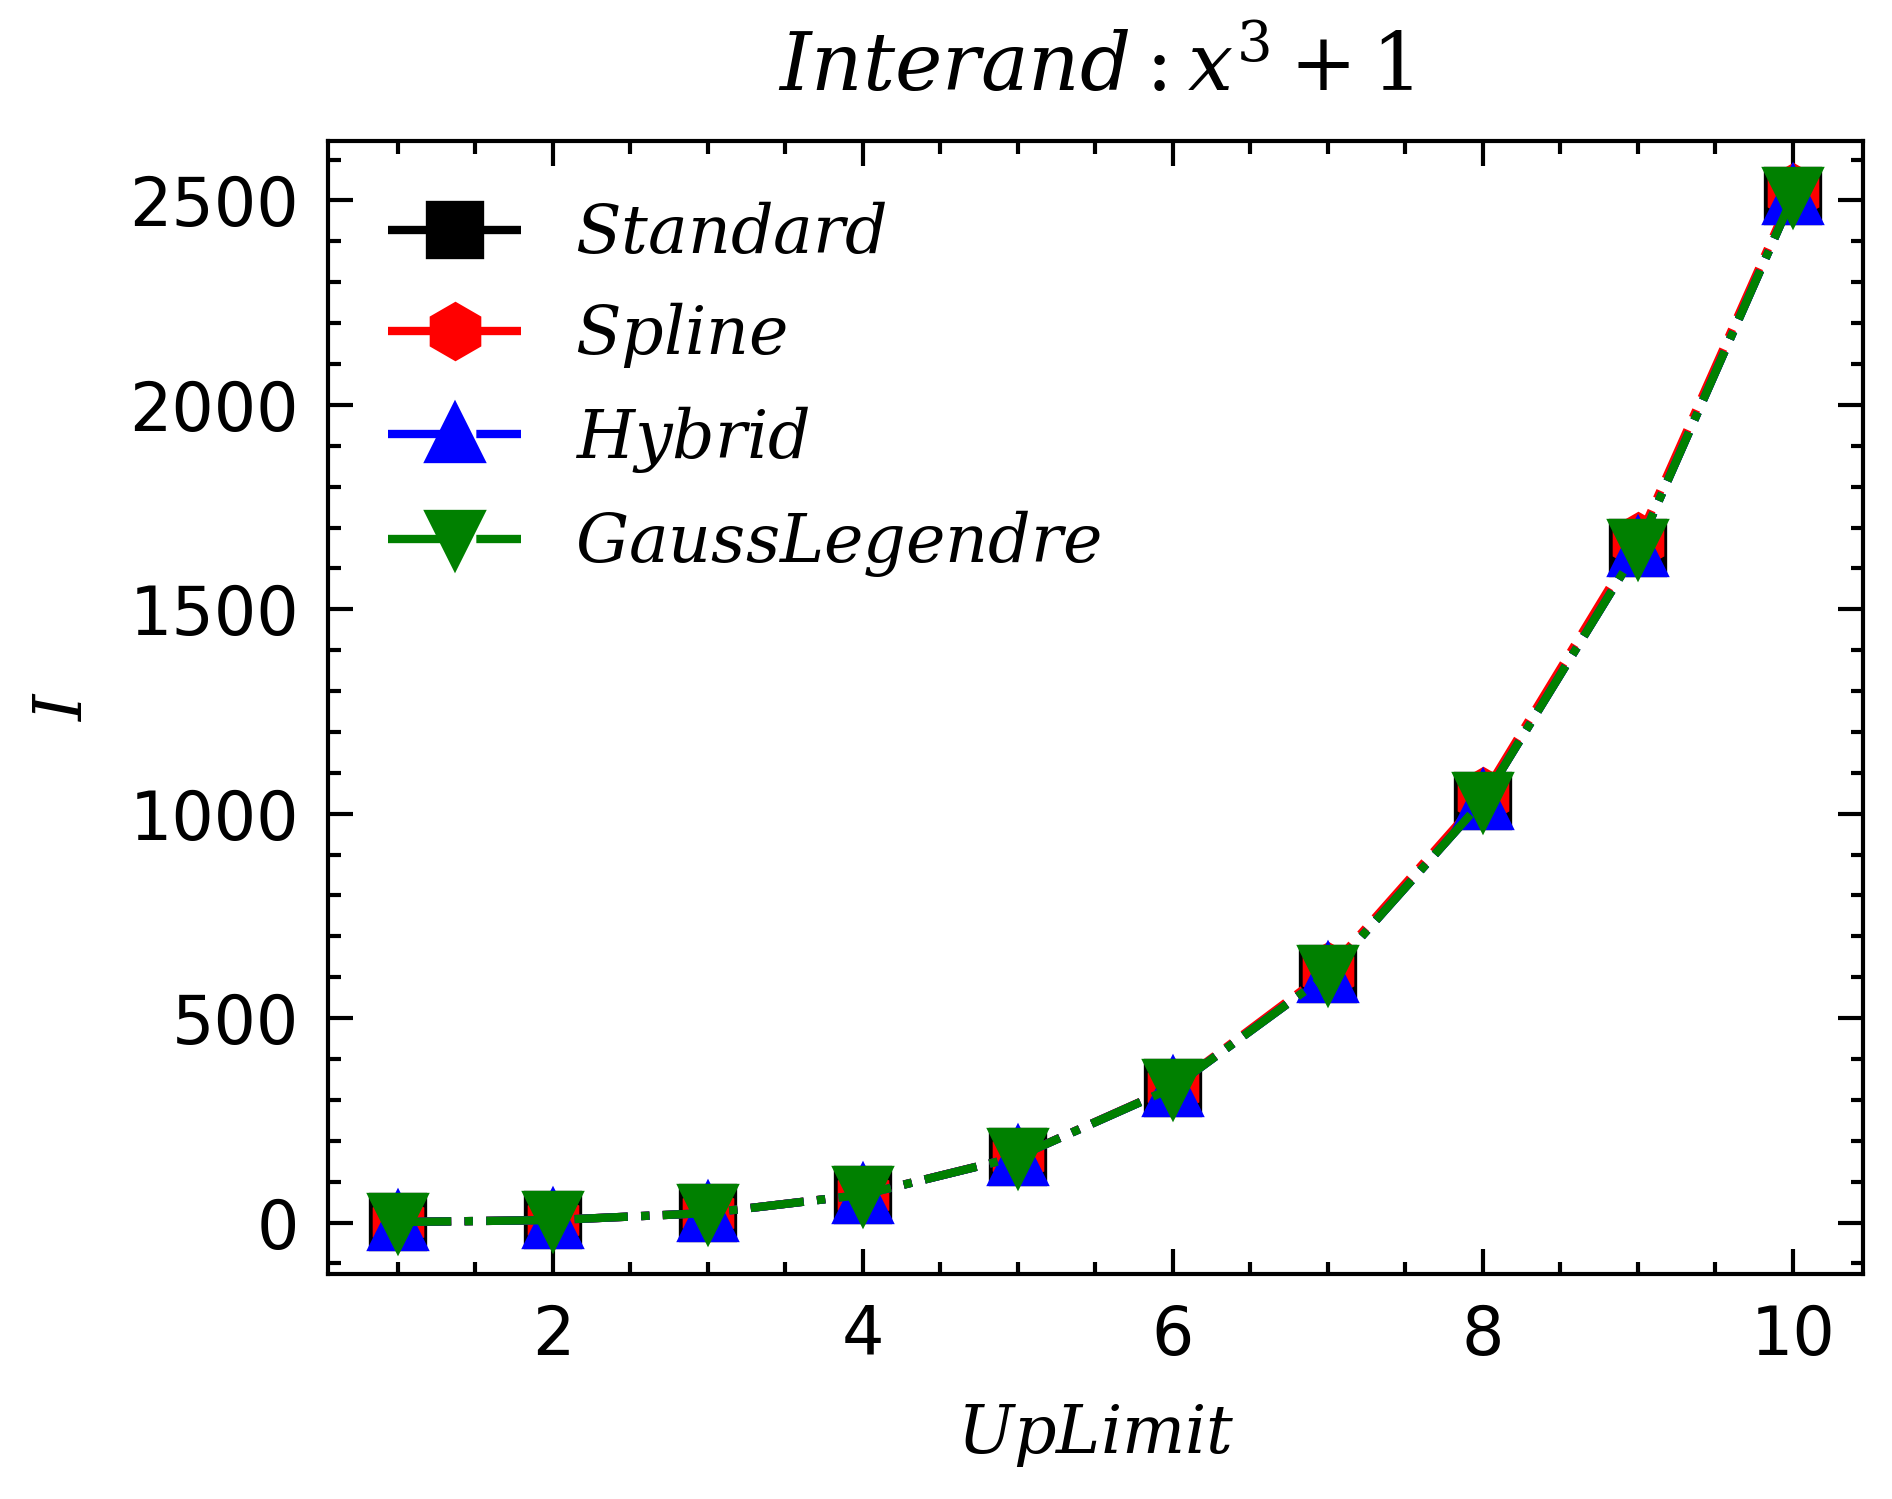

In [12]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use(['science','ieee','no-latex'])
upLimit=np.linspace(1,10,10)
standard=upLimit**4/4+upLimit
testResult= np.loadtxt("x3test.txt", delimiter=',')
plt.figure()
plt.plot(upLimit,standard,'s-.')
plt.plot(upLimit,testResult[:,0],'h-.')
plt.plot(upLimit,testResult[:,1],'^-.')
plt.plot(upLimit,testResult[:,2],'v-.')
plt.title(r"$Interand:x^3+1$")
plt.xlabel(r"$UpLimit$")
plt.ylabel(r"$I$")
plt.legend([r"$Standard$",r"$Spline$",r"$Hybrid$",r"$GaussLegendre$"])